In [1]:
# from google.colab import drive
# drive.mount("mnt")

# %cd "mnt/My Drive/Colab Notebooks/adversarial_examples/results"

# !pip install import-ipynb
# import import_ipynb

In [4]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from pymoo.indicators.hv import Hypervolume
from scipy.stats import wilcoxon

In [5]:
class_dictionary = {0:"Airplane",
                   1:"Car",
                   2:"Bird",
                   3:"Cat",
                   4:"Deer",
                   5:"Dog",
                   6:"Frog",
                   7:"Horse",
                   8:"Ship",
                   9:"Truck"}

# Standard - Working directory

In [6]:
%pwd
%cd "results"
%cd "CIFAR10"
%cd "WideResNet2810"

[Errno 2] No such file or directory: 'results'
/Users/jaredratto/Library/CloudStorage/GoogleDrive-jared.ratto@gmail.com/My Drive/Colab Notebooks/adversarial_examples/results/CIFAR10/WideResNet2810
[Errno 2] No such file or directory: 'CIFAR10'
/Users/jaredratto/Library/CloudStorage/GoogleDrive-jared.ratto@gmail.com/My Drive/Colab Notebooks/adversarial_examples/results/CIFAR10/WideResNet2810
[Errno 2] No such file or directory: 'WideResNet2810'
/Users/jaredratto/Library/CloudStorage/GoogleDrive-jared.ratto@gmail.com/My Drive/Colab Notebooks/adversarial_examples/results/CIFAR10/WideResNet2810


# Standard Network Summary

In [7]:
# This is the one that works. Change from standard to standard though
length = 200
standard_x_coords = np.empty((0,length))
standard_y_coords = np.empty((0,length))
# Do this for each of the 10 CIFAR classes
for selected_class in range(10):
  # Resetting variables
  selected_class = str(selected_class)
  l0 = np.empty(0)
  linf = np.empty(0)
  label = 0
  img_labels = np.empty(0)

  # Gather all the files of an individual class and append the arrays of l0, linf, and img_labels. Combine these into the array a.
  for i in os.listdir():
    if i[0] == selected_class:
      # individual output file level
      temp_dict = np.load(i,allow_pickle=True)
      temp_dict = np.expand_dims(temp_dict,axis=0)[0]
      for j in temp_dict['front0_fitness']:
        l0 = np.append(l0,(j[1]))
        linf = np.append(linf,(j[2][0]))
      img_labels = np.append(img_labels,np.ones(len(temp_dict['front0_fitness'])) * label )
      label+=1
  l0 = l0/1024
  a = np.hstack((linf.reshape((-1,1)),l0.reshape((-1,1)))).copy()

  # x and y array are the arrays of interpolated x and y coordinates for the fronts of an individual class
  x_array = np.empty((0,length))
  y_array = np.empty((0,length))
  # loop: the interpolation of individual fronts within a class, and then averaging them
  for i in range(max((img_labels).astype(int))):
    a_i = a[img_labels==i].copy()
    min_a_x, max_a_x = min(a_i[:,0]), max(a_i[:,0])
    new_a_x = np.linspace(min_a_x, max_a_x, length).reshape((1,length))
    new_a_y = np.interp(new_a_x, a_i[:,0], a_i[:,1]).reshape((1,length))

    x_array = np.vstack((x_array,new_a_x))
    y_array = np.vstack((y_array,new_a_y))
  # taking each "average front" and then forming the 2 grand arrays for the 10 classes
  standard_x_coords = np.vstack((standard_x_coords,np.mean(x_array,axis=0)))
  standard_y_coords = np.vstack((standard_y_coords,np.mean(y_array,axis=0)))

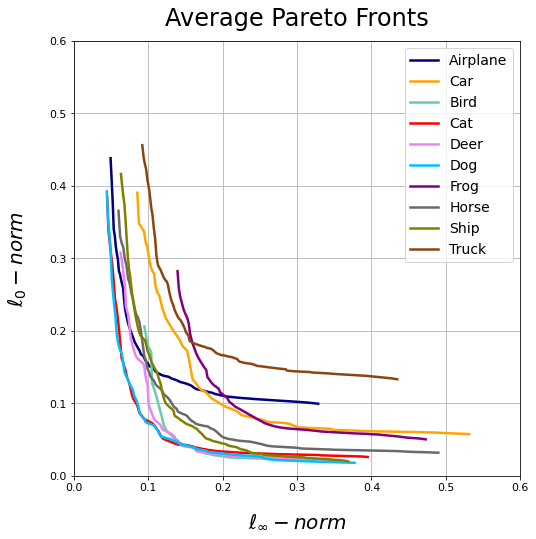

In [9]:
plt.figure(figsize=(8,8))
color_list = ['navy','orange','mediumaquamarine','red','violet','deepskyblue','purple','dimgray','olive','saddlebrown']
for j in range(10):
    plt.plot(standard_x_coords[j],standard_y_coords[j],color=color_list[j],linewidth=2.5,label = class_dictionary[j])
#     plt.plot(standard_x_coords[j],standard_y_coords[j],linewidth=2.5,color=(np.ones(200)*j).astype(int),cmap='Accent',label = class_dictionary[j])
plt.xlim(0,0.6)
plt.ylim(0,0.6)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel(r'$\ell_\infty- norm$',labelpad=20,size=20)
plt.ylabel(r'$\ell_0- norm$',labelpad=20,size=20)
plt.title("Average Pareto Fronts",pad=15,size=24)
plt.legend(fontsize="14",loc='upper right')
plt.grid()
# plt.savefig("all_classes.png")
plt.show()

## Network Summary

In [10]:
# Find a flat array of hypervolumes
hv_array = np.empty(0)
reference_point = np.array([1.0, 1.0])
for i in range(10):
    pareto_front = np.hstack((standard_y_coords[i].reshape((-1,1)),standard_x_coords[i].reshape((-1,1))))
    hypervolume_calculator = Hypervolume(ref_point=reference_point)
    hypervolume = hypervolume_calculator.do(pareto_front)
    hv_array = np.append(hv_array,hypervolume)

In [11]:
# np.min(standard_x_coords,axis=1) # This represents the robustness limit of the l-inf norm
# np.min(standard_y_coords,axis=1) # This represents the robustness limit of the l-0 norm
network0_summary = np.hstack((np.min(standard_x_coords,axis=1).reshape((-1,1)),np.min(standard_y_coords,axis=1).reshape((-1,1)),hv_array.reshape((-1,1))))

In [12]:
network0_summary

array([[0.04934681, 0.0994873 , 0.84566619],
       [0.08525806, 0.05745443, 0.84287185],
       [0.09472599, 0.02106585, 0.88133674],
       [0.04477681, 0.02587891, 0.92004234],
       [0.06277717, 0.02064732, 0.90795303],
       [0.04426407, 0.01794434, 0.92684816],
       [0.13932927, 0.05026042, 0.8057065 ],
       [0.0599794 , 0.03183594, 0.89369855],
       [0.06325151, 0.01970881, 0.90148098],
       [0.0919894 , 0.13320313, 0.77243343]])

# Defended Network Summary

Change directory to the results of either adversarially trained network you are studying

In [14]:
# Change working directory
%pwd
%cd ..
%cd WideResNet_defended

/Users/jaredratto/Library/CloudStorage/GoogleDrive-jared.ratto@gmail.com/My Drive/Colab Notebooks/adversarial_examples/results/CIFAR10
/Users/jaredratto/Library/CloudStorage/GoogleDrive-jared.ratto@gmail.com/My Drive/Colab Notebooks/adversarial_examples/results/CIFAR10/WideResNet_defended


In [15]:
# This is the one that works. Change from defend to defend though
length = 200
defend_x_coords = np.empty((0,length))
defend_y_coords = np.empty((0,length))
# Do this for each of the 10 CIFAR classes
for selected_class in range(10):
  # Resetting variables
  selected_class = str(selected_class)
  l0 = np.empty(0)
  linf = np.empty(0)
  label = 0
  img_labels = np.empty(0)
  print(selected_class)
  # Gather all the files of an individual class and append the arrays of l0, linf, and img_labels. Combine these into the array a.
  for i in os.listdir():
    if i[0] == selected_class:
#       print("True")
      # individual output file level
      temp_dict = np.load(i,allow_pickle=True)
      temp_dict = np.expand_dims(temp_dict,axis=0)[0]
      for j in temp_dict['front0_fitness']:
#         print(j[1])
        l0 = np.append(l0,(j[1]))
        linf = np.append(linf,(j[2][0]))
      img_labels = np.append(img_labels,np.ones(len(temp_dict['front0_fitness'])) * label )
      label+=1
#     print(i)
  l0 = l0/1024
  a = np.hstack((linf.reshape((-1,1)),l0.reshape((-1,1)))).copy()

  # x and y array are the arrays of interpolated x and y coordinates for the fronts of an individual class
  x_array = np.empty((0,length))
  y_array = np.empty((0,length))
  # loop: the interpolation of individual fronts within a class, and then averaging them
  for i in range(max((img_labels).astype(int))):
    a_i = a[img_labels==i].copy()
    min_a_x, max_a_x = min(a_i[:,0]), max(a_i[:,0])
    new_a_x = np.linspace(min_a_x, max_a_x, length).reshape((1,length))
    new_a_y = np.interp(new_a_x, a_i[:,0], a_i[:,1]).reshape((1,length))

    x_array = np.vstack((x_array,new_a_x))
    y_array = np.vstack((y_array,new_a_y))
  # taking each "average front" and then forming the 2 grand arrays for the 10 classes
  defend_x_coords = np.vstack((defend_x_coords,np.mean(x_array,axis=0)))
  defend_y_coords = np.vstack((defend_y_coords,np.mean(y_array,axis=0)))

0
1
2
3
4
5
6
7
8
9


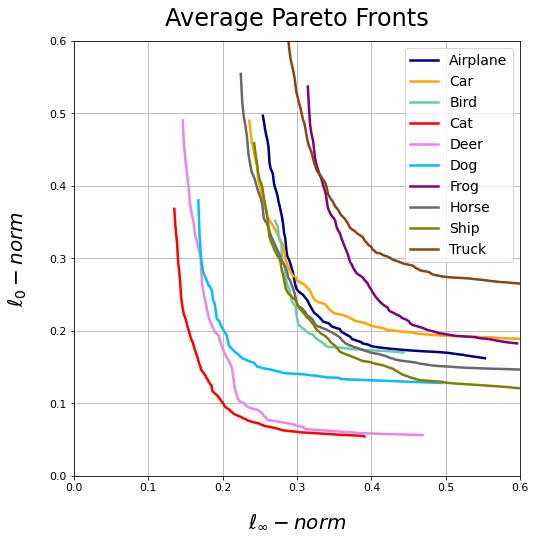

In [18]:
plt.figure(figsize=(8,8))
color_list = ['navy','orange','mediumaquamarine','red','violet','deepskyblue','purple','dimgray','olive','saddlebrown']
for j in range(10):
    plt.plot(defend_x_coords[j],defend_y_coords[j],color=color_list[j],linewidth=2.5,label = class_dictionary[j])
#     plt.plot(defend_x_coords[j],defend_y_coords[j],linewidth=2.5,color=(np.ones(200)*j).astype(int),cmap='Accent',label = class_dictionary[j])
plt.xlim(0,0.6)
plt.ylim(0,0.6)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel(r'$\ell_\infty- norm$',labelpad=20,size=20)
plt.ylabel(r'$\ell_0- norm$',labelpad=20,size=20)
plt.title("Average Pareto Fronts",pad=15,size=24)
plt.legend(fontsize="14",loc='upper right')
plt.grid()
# plt.savefig("all_classes.png")
plt.show()

In [19]:
# Find a flat array of hypervolumes
hv_array = np.empty(0)
reference_point = np.array([1.0, 1.0])
for i in range(10):
    pareto_front = np.hstack((defend_y_coords[i].reshape((-1,1)),defend_x_coords[i].reshape((-1,1))))
    hypervolume_calculator = Hypervolume(ref_point=reference_point)
    hypervolume = hypervolume_calculator.do(pareto_front)
    hv_array = np.append(hv_array,hypervolume)
    
network1_summary = np.hstack((np.min(defend_x_coords,axis=1).reshape((-1,1)),np.min(defend_y_coords,axis=1).reshape((-1,1)),hv_array.reshape((-1,1))))


In [20]:
network1_summary

array([[0.25403101, 0.16221788, 0.60927178],
       [0.23590816, 0.18736049, 0.6041499 ],
       [0.27037307, 0.17020089, 0.60070907],
       [0.13502478, 0.05414497, 0.80771842],
       [0.14630826, 0.05615234, 0.78838499],
       [0.1673109 , 0.12809245, 0.71789108],
       [0.31452144, 0.18268229, 0.54209239],
       [0.22431147, 0.14248047, 0.64100934],
       [0.24231103, 0.11962891, 0.64603415],
       [0.28562332, 0.25791016, 0.50727342]])

# Compare Standard vs Defended

In [21]:
defend_x_coords.shape
x_diff = np.average(defend_x_coords - standard_x_coords,axis=1).reshape((-1,1))
y_diff = np.average(defend_y_coords - standard_y_coords,axis=1).reshape((-1,1))
hv_diff = (network0_summary[:,2] - network1_summary[:,2]).reshape((-1,1))

diff_summary = np.hstack((x_diff,y_diff,hv_diff))

In [22]:
diff_summary

array([[0.21438024, 0.07791805, 0.23639441],
       [0.1269404 , 0.12870806, 0.23872196],
       [0.14776865, 0.15522856, 0.28062768],
       [0.04288348, 0.03914722, 0.11232392],
       [0.10004883, 0.05501636, 0.11956804],
       [0.12057714, 0.09975278, 0.20895708],
       [0.14900344, 0.16176787, 0.26361411],
       [0.15518597, 0.13109818, 0.25268921],
       [0.21053158, 0.10193025, 0.25544682],
       [0.20833719, 0.14336674, 0.26516001]])

## Wilcoxon

In [24]:
# Compare the classes' hypervolumes between the two networks
d1 = network0_summary[:,0]
d2 = network1_summary[:,0]
res = wilcoxon(d1,d2)
res.statistic, res.pvalue
# We can reject the null hypothesis that the two hypervolume sets are the same. 
# Standard is definitely more vulnerable than defended

(0.0, 0.001953125)